In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [51]:
files = glob('./data/assignments/*.csv', 
                   recursive = True)
df = pd.concat([pd.read_csv(f) for f in files])
# df.loaded_distance = df.loaded_distance.apply(lambda x: x.replace(' mi', '')).astype(float) # Formatting loaded_distance
df['origin'] = pd.Series(zip(df.origin_lat, df.origin_lng))
df['destination'] = pd.Series(zip(df.destination_lat, df.destination_lng))
df = df.drop(['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'], axis=1)
df['trip_type'] = np.NaN
# df = df[:len(df)//100]
df.head()

,id,loaded_distance,appt_date,appt_time,client_id,driver_id,program_name,origin,destination,trip_type
0,488034,92.6 mi,2021-09-01,16:30,14352,397,NaN,"(44.38, -75.71)","(43.25, -76.23)",NaN
1,488036,52.6 mi,2021-09-01,06:30,12181,495,ONE,"(43.06, -72.45)","(43.68, -72.27)",NaN
2,488037,92.6 mi,2021-09-01,16:30,14353,397,NaN,"(44.38, -75.71)","(43.25, -76.23)",NaN
3,488038,53.5 mi,2021-09-01,08:40,12181,495,ONE,"(43.68, -72.27)","(43.06, -72.45)",NaN
4,488039,27.2 mi,2021-09-01,16:30,3852,466,NaN,"(43.9, -75.67)","(43.62, -75.36)",NaN


In [52]:
df.shape

(188078, 10)

### Trips classification
For now, we define one trip per day per client, and there are 3 types of trips:
- One-way trip: a trip with only 1 leg.
- Round trip: a trip with 2 legs that has the same origin and destination
- Round multi-leg trip: a trip with 3 or more legs that has the same origin and destination
- Non-round multi-leg trip: a trip with **2** or more legs that has the different origin and destination origin and destination. <br>

In [53]:
def classify_trip(df):
    df = df.sort_values('appt_time', ascending=True)
    if len(df) == 0:
        return df
    if len(df) == 1:
        df.trip_type = 'one-way'
        return df
    if df.iloc[0].origin == df.iloc[-1].destination:
        if len(df) == 2:
            df.trip_type = 'round'
            return df
        df.trip_type = 'round multi-leg'
        return df
    df.trip_type = 'non-round multi-leg'
    return df

df = df.groupby(['client_id','appt_date'], group_keys=True).apply(classify_trip).drop(['appt_time', 'client_id'], axis=1)
df.head(20)
# May take around 40s to run

id loaded_distance   appt_date  driver_id  \
client_id appt_date                                                         
48        2021-07-28 12961  470677         94.9 mi  2021-07-28        470   
                     13448  471164          318 mi  2021-07-28        470   
                     13324  471040         94.9 mi  2021-07-28        470   
          2021-08-18 7933   480834         30.5 mi  2021-08-18        235   
                     8067   480968         29.7 mi  2021-08-18        235   
          2021-08-23 10537  483442         37.2 mi  2021-08-23        535   
                     10741  483646         37.2 mi  2021-08-23        535   
          2021-08-26 12399  485305         37.2 mi  2021-08-26        179   
                     12638  485544         37.2 mi  2021-08-26        179   
          2021-08-27 12907  485813         90.9 mi  2021-08-27        177   
                     13123  486029         96.2 mi  2021-08-27        177   
          2021-09-14 5733   493792         95.7 mi  2021-09-14        236   
                     6037   494096         96.4 mi  2021-09-14        236   
          2021-10-11 4369   506382         93.8 mi  2021-10-11        236   
                     4627   506640         94.7 mi  2021-10-11        236   
          2022-07-28 14258  665730         95.3 mi  2022-07-28        129   
                     14431  665903         96.4 mi  2022-07-28        129   
          2022-10-31 15314  716051         96.9 mi  2022-10-31        232   
                     15650  716387         96.4 mi  2022-10-31        232   
          2022-11-17 9499   726084         96.9 mi  2022-11-17        129   

                           program_name           origin      destination  \
client_id appt_date                                                         
48        2021-07-28 12961       STLMCD  (43.12, -71.89)   (43.2, -71.56)   
                     13448       STLMCD   (43.58, -71.2)  (43.53, -71.47)   
                     13324       STLMCD  (44.15, -75.72)  (44.33, -75.92)   
          2021-08-18 7933        STLMCD  (43.98, -75.92)  (44.16, -75.81)   
                     8067        STLMCD  (44.68, -74.97)  (44.66, -75.03)   
          2021-08-23 10537       STLMCD  (44.34, -75.92)  (44.07, -75.92)   
                     10741       STLMCD  (43.95, -75.91)  (43.78, -76.22)   
          2021-08-26 12399       STLMCD  (44.97, -74.85)   (44.7, -73.47)   
                     12638       STLMCD  (43.95, -75.91)   (44.2, -75.06)   
          2021-08-27 12907       STLMCD  (43.74, -75.34)  (43.98, -75.92)   
                     13123       STLMCD  (43.06, -76.15)  (43.95, -75.92)   
          2021-09-14 5733        STLMCD  (44.93, -74.89)  (43.95, -75.91)   
                     6037        STLMCD  (43.95, -75.91)  (44.93, -74.89)   
          2021-10-11 4369        STLMCD  (43.98, -75.92)  (44.15, -75.71)   
                     4627        STLMCD  (43.98, -75.92)  (44.61, -75.59)   
          2022-07-28 14258       STLMCD  (44.68, -73.45)  (44.93, -74.89)   
                     14431       STLMCD  (44.61, -75.13)  (44.84, -74.99)   
          2022-10-31 15314       STLMCD  (39.95, -75.17)  (44.14, -75.72)   
                     15650       STLMCD  (43.95, -75.91)  (43.98, -75.61)   
          2022-11-17 9499        STLMCD  (44.85, -75.24)   (44.86, -75.2)   

                                      trip_type  
client_id appt_date                              
48        2021-07-28 12961  non-round multi-leg  
                     13448  non-round multi-leg  
                     13324  non-round multi-leg  
          2021-08-18 7933   non-round multi-leg  
                     8067   non-round multi-leg  
          2021-08-23 10537  non-round multi-leg  
                     10741  non-round multi-leg  
          2021-08-26 12399  non-round multi-leg  
                     12638  non-round multi-leg  
          2021-08-27 12907  non-round multi-leg  
                     13123  non-round mult

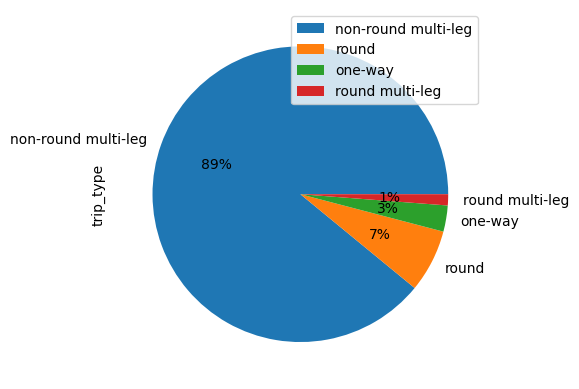

In [57]:
df.trip_type.value_counts().plot(kind='pie',autopct='%0.0f%%', legend=True);

In [58]:
df.trip_type.value_counts()

non-round multi-leg    167499
round                   12916
one-way                  5371
round multi-leg          2292
Name: trip_type, dtype: int64

In [59]:
df.to_csv('assignments_classified.csv')